In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
hist_trans_df = pd.read_csv("E:\DSE\DataStorm 4.0\DataStorm077\data-storm-4\Historical-transaction-data.csv")
store_info_df = pd.read_csv('E:\DSE\DataStorm 4.0\DataStorm077\data-storm-4\Store-info.csv')
test_df = pd.read_csv('E:\DSE\DataStorm 4.0\DataStorm077\data-storm-4\Testing-data.csv')

In [13]:
hist_trans_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


In [14]:
# Merge two csv files based on shop_id
df = pd.merge(hist_trans_df, store_info_df, on='shop_id' ,how='right')

In [15]:
df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,SODA 1L,2021-10-17T00:00:00.000Z,30956.0,4OFQ,SHOP047,110,1,528,Moderate
1,ORANGE BARLEY 1.5L,2021-10-20T00:00:00.000Z,31418.0,KQYP,SHOP047,220,1,528,Moderate
2,GINGER BEER 1.5L,2021-11-01T00:00:00.000Z,33467.0,WCZT,SHOP047,220,2,528,Moderate
3,FIT O MIXED FRUIT 200ML,2021-11-06T00:00:00.000Z,34265.0,KD8T,SHOP047,60,1,528,Moderate
4,GINGER BEER 1.5L,2021-11-06T00:00:00.000Z,34265.0,KD8T,SHOP047,220,2,528,Moderate


In [16]:
# Get the Sale Amount for each transaction
df['sale_amount'] = df['item_price'] * df['quantity_sold']

In [17]:
# create month and year columns
df['transaction_date'] = pd.to_datetime(hist_trans_df['transaction_date'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors='raise')
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month

In [18]:
df['year'].unique()

array([2021], dtype=int64)

Since we only have data from year 2021, we can drop year column and the transaction date column.

In [19]:
df.drop(['year', 'transaction_date'], axis=1, inplace=True)

In [20]:
df

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month
0,SODA 1L,30956.0,4OFQ,SHOP047,110,1,528,Moderate,110,12
1,ORANGE BARLEY 1.5L,31418.0,KQYP,SHOP047,220,1,528,Moderate,220,10
2,GINGER BEER 1.5L,33467.0,WCZT,SHOP047,220,2,528,Moderate,440,12
3,FIT O MIXED FRUIT 200ML,34265.0,KD8T,SHOP047,60,1,528,Moderate,60,12
4,GINGER BEER 1.5L,34265.0,KD8T,SHOP047,220,2,528,Moderate,440,10
...,...,...,...,...,...,...,...,...,...,...
473969,CREAM SODA APPLE POP 1L,2182136.0,FGBA,SHOP070,150,1,676,NaN,150,12
473970,GINGER BEER 1.5L,2183207.0,DSXF,SHOP070,220,1,676,NaN,220,12
473971,SODA 1L,3897834.0,WSFD,SHOP070,110,2,676,NaN,220,11
473972,ORANGE CRUSH 500ML,3898615.0,6096,SHOP070,100,2,676,NaN,200,12


# Drop invalid values

In [21]:
# drop rows with quantity_sold <= 0
hist_trans_df.drop(hist_trans_df[hist_trans_df['quantity_sold'] <= 0].index, inplace=True)

In [22]:
# items sold by each shop
temp_df3 = pd.DataFrame(hist_trans_df.groupby(['shop_id', 'item_description'])['quantity_sold'].sum()).reset_index()
temp_df3.rename(columns={'quantity_sold': 'quantity_sold_per_item'}, inplace=True)

# create a column by extracting the bottle size in letres(L) from item_description, if in milileters(ml) convert to L
size = temp_df3['item_description'].str.extract(r'(\d+[.]*\d*)(ML|L)')
size.rename(columns={0: 'size', 1: 'unit'}, inplace=True)

# convert ml to L 
size['size'] = np.where(size['unit'] == 'ML', size['size'].astype(float) / 1000, size['size'].astype(float))
size.drop(columns='unit', inplace=True)

# concat size to temp_df3
temp_df3 = pd.concat([temp_df3, size], axis=1)
temp_df3.rename(columns={'size': 'bottle_size'}, inplace=True)

df = pd.merge(df, temp_df3, on=['shop_id', 'item_description'], how='left')

df['item_description'] = df['item_description'].str.replace(r'\d+[.]*\d*(ML|L)', '', regex=True)

In [23]:
df

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month,quantity_sold_per_item,bottle_size
0,SODA,30956.0,4OFQ,SHOP047,110,1,528,Moderate,110,12,88.0,1.0
1,ORANGE BARLEY,31418.0,KQYP,SHOP047,220,1,528,Moderate,220,10,113.0,1.5
2,GINGER BEER,33467.0,WCZT,SHOP047,220,2,528,Moderate,440,12,306.0,1.5
3,FIT O MIXED FRUIT,34265.0,KD8T,SHOP047,60,1,528,Moderate,60,12,44.0,0.2
4,GINGER BEER,34265.0,KD8T,SHOP047,220,2,528,Moderate,440,10,306.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...
473969,CREAM SODA APPLE POP,2182136.0,FGBA,SHOP070,150,1,676,NaN,150,12,170.0,1.0
473970,GINGER BEER,2183207.0,DSXF,SHOP070,220,1,676,NaN,220,12,882.0,1.5
473971,SODA,3897834.0,WSFD,SHOP070,110,2,676,NaN,220,11,130.0,1.0
473972,ORANGE CRUSH,3898615.0,6096,SHOP070,100,2,676,NaN,200,12,35.0,0.5


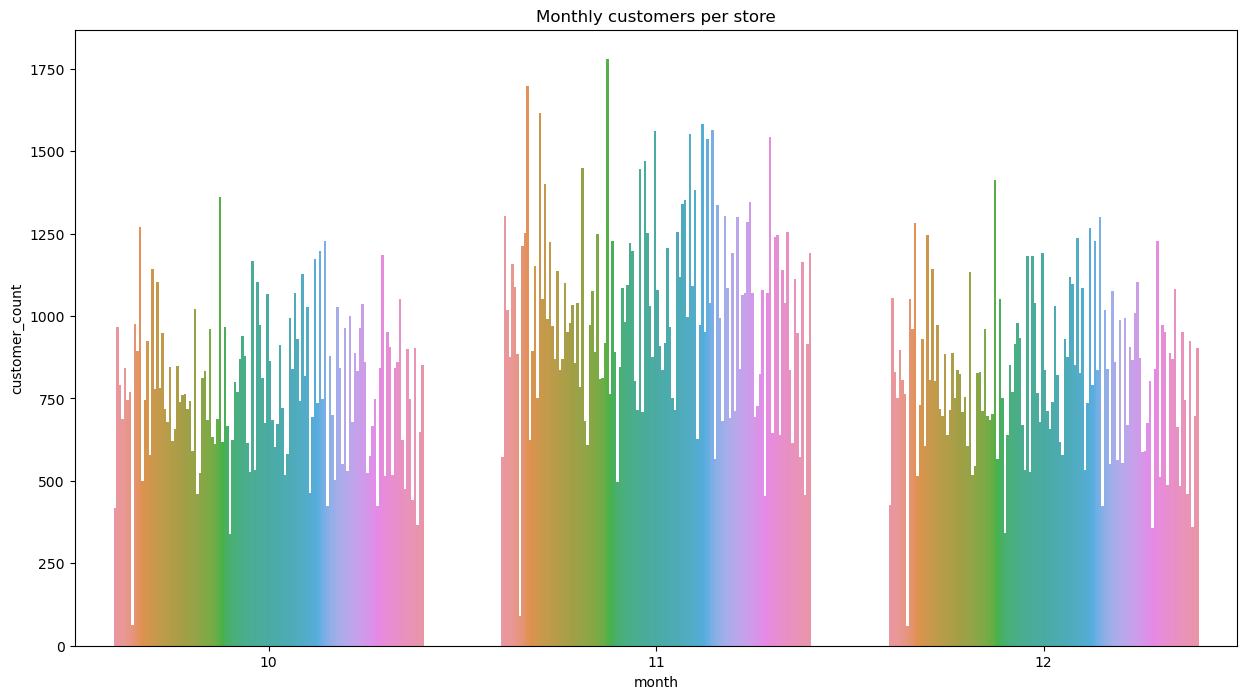

In [24]:
# monthly customers per store
customer_count = df.groupby(['shop_id', 'month'])['customer_id'].nunique()
customer_count.rename('customer_count', inplace=True)

# clusted barchart of monthly customers per store
customer_count_df = pd.DataFrame(customer_count.reset_index())

# plot sales on monthly basis
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='month', y='customer_count', hue='shop_id', data=customer_count_df)
plt.title('Monthly customers per store')
ax.legend().set_visible(False)

plt.show()

In [25]:
df = pd.merge(df, customer_count_df, on=['shop_id', 'month'], how='left')

In [26]:
df

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month,quantity_sold_per_item,bottle_size,customer_count
0,SODA,30956.0,4OFQ,SHOP047,110,1,528,Moderate,110,12,88.0,1.0,343
1,ORANGE BARLEY,31418.0,KQYP,SHOP047,220,1,528,Moderate,220,10,113.0,1.5,340
2,GINGER BEER,33467.0,WCZT,SHOP047,220,2,528,Moderate,440,12,306.0,1.5,343
3,FIT O MIXED FRUIT,34265.0,KD8T,SHOP047,60,1,528,Moderate,60,12,44.0,0.2,343
4,GINGER BEER,34265.0,KD8T,SHOP047,220,2,528,Moderate,440,10,306.0,1.5,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
473969,CREAM SODA APPLE POP,2182136.0,FGBA,SHOP070,150,1,676,NaN,150,12,170.0,1.0,619
473970,GINGER BEER,2183207.0,DSXF,SHOP070,220,1,676,NaN,220,12,882.0,1.5,619
473971,SODA,3897834.0,WSFD,SHOP070,110,2,676,NaN,220,11,130.0,1.0,752
473972,ORANGE CRUSH,3898615.0,6096,SHOP070,100,2,676,NaN,200,12,35.0,0.5,619


In [27]:
temp = pd.DataFrame(hist_trans_df.groupby('shop_id')['quantity_sold'].sum()).reset_index()
temp.rename(columns={'quantity_sold': 'quantity_sold_per_shop'}, inplace=True)

df = pd.merge(df, temp, on='shop_id', how='left')
df

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month,quantity_sold_per_item,bottle_size,customer_count,quantity_sold_per_shop
0,SODA,30956.0,4OFQ,SHOP047,110,1,528,Moderate,110,12,88.0,1.0,343,3288
1,ORANGE BARLEY,31418.0,KQYP,SHOP047,220,1,528,Moderate,220,10,113.0,1.5,340,3288
2,GINGER BEER,33467.0,WCZT,SHOP047,220,2,528,Moderate,440,12,306.0,1.5,343,3288
3,FIT O MIXED FRUIT,34265.0,KD8T,SHOP047,60,1,528,Moderate,60,12,44.0,0.2,343,3288
4,GINGER BEER,34265.0,KD8T,SHOP047,220,2,528,Moderate,440,10,306.0,1.5,340,3288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473969,CREAM SODA APPLE POP,2182136.0,FGBA,SHOP070,150,1,676,NaN,150,12,170.0,1.0,619,5028
473970,GINGER BEER,2183207.0,DSXF,SHOP070,220,1,676,NaN,220,12,882.0,1.5,619,5028
473971,SODA,3897834.0,WSFD,SHOP070,110,2,676,NaN,220,11,130.0,1.0,752,5028
473972,ORANGE CRUSH,3898615.0,6096,SHOP070,100,2,676,NaN,200,12,35.0,0.5,619,5028


In [28]:
# total income per store monthly 
temp_df = pd.DataFrame()
temp_df['total'] = df['quantity_sold'] * df['item_price']
temp_df = pd.concat([df, temp_df], axis=1)

new_df = pd.DataFrame(temp_df.groupby(['shop_id', 'month'])['total'].sum()).reset_index()

df = pd.merge(df, new_df, on=['shop_id', 'month'], how='left')
df

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month,quantity_sold_per_item,bottle_size,customer_count,quantity_sold_per_shop,total
0,SODA,30956.0,4OFQ,SHOP047,110,1,528,Moderate,110,12,88.0,1.0,343,3288,200535
1,ORANGE BARLEY,31418.0,KQYP,SHOP047,220,1,528,Moderate,220,10,113.0,1.5,340,3288,303195
2,GINGER BEER,33467.0,WCZT,SHOP047,220,2,528,Moderate,440,12,306.0,1.5,343,3288,200535
3,FIT O MIXED FRUIT,34265.0,KD8T,SHOP047,60,1,528,Moderate,60,12,44.0,0.2,343,3288,200535
4,GINGER BEER,34265.0,KD8T,SHOP047,220,2,528,Moderate,440,10,306.0,1.5,340,3288,303195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473969,CREAM SODA APPLE POP,2182136.0,FGBA,SHOP070,150,1,676,NaN,150,12,170.0,1.0,619,5028,461160
473970,GINGER BEER,2183207.0,DSXF,SHOP070,220,1,676,NaN,220,12,882.0,1.5,619,5028,461160
473971,SODA,3897834.0,WSFD,SHOP070,110,2,676,NaN,220,11,130.0,1.0,752,5028,569595
473972,ORANGE CRUSH,3898615.0,6096,SHOP070,100,2,676,NaN,200,12,35.0,0.5,619,5028,461160


<Axes: xlabel='shop_area_sq_ft', ylabel='customer_count'>

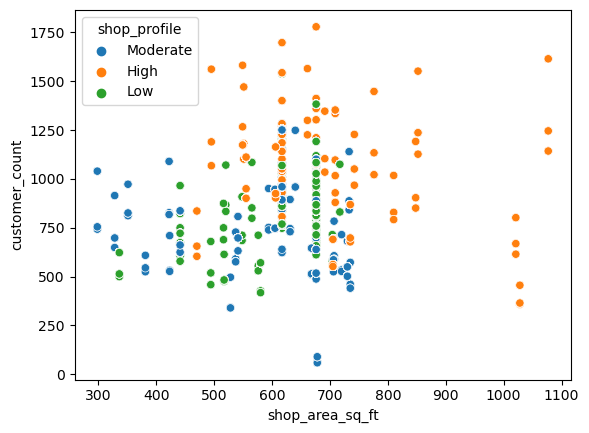

In [29]:
# scatterplot for monthly sales, square_feet and customer_count
sns.scatterplot(x='shop_area_sq_ft', y='customer_count', hue='shop_profile', data=df)

C:\Users\tharo\AppData\Local\Temp\ipykernel_21096\2674289365.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop(columns=['shop_id', 'item_description', 'invoice_id', 'shop_profile']).corr()


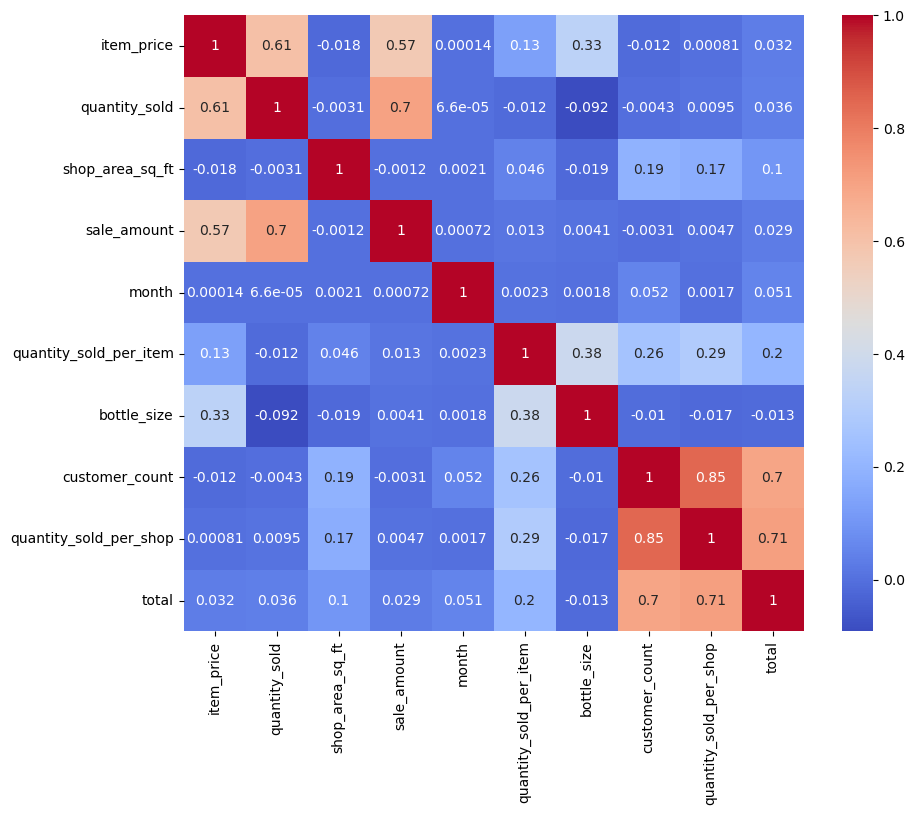

In [30]:
# correlation matrix
corr = df.drop(columns=['shop_id', 'item_description', 'invoice_id', 'shop_profile']).corr()

# heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.show()

In [31]:
df2 = df.dropna(subset=['shop_profile'])
df2

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month,quantity_sold_per_item,bottle_size,customer_count,quantity_sold_per_shop,total
0,SODA,30956.0,4OFQ,SHOP047,110,1,528,Moderate,110,12,88.0,1.0,343,3288,200535
1,ORANGE BARLEY,31418.0,KQYP,SHOP047,220,1,528,Moderate,220,10,113.0,1.5,340,3288,303195
2,GINGER BEER,33467.0,WCZT,SHOP047,220,2,528,Moderate,440,12,306.0,1.5,343,3288,200535
3,FIT O MIXED FRUIT,34265.0,KD8T,SHOP047,60,1,528,Moderate,60,12,44.0,0.2,343,3288,200535
4,GINGER BEER,34265.0,KD8T,SHOP047,220,2,528,Moderate,440,10,306.0,1.5,340,3288,303195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387336,GINGER BEER,5183689.0,UNOY,SHOP101,220,1,691,High,220,12,1148.0,1.5,1104,9265,788825
387337,LEMONADE,6270943.0,B675,SHOP101,100,1,691,High,100,12,135.0,0.5,1104,9265,788825
387338,GINGER BEER,NaN,FTCU,SHOP101,220,1,691,High,220,12,1148.0,1.5,1104,9265,788825
387339,FIT O MANGO,NaN,M0LJ,SHOP101,290,0,691,High,0,11,131.0,1.0,1347,9265,951395


In [32]:
df_test = df[pd.isnull(df['shop_profile'])]
df_test

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,sale_amount,month,quantity_sold_per_item,bottle_size,customer_count,quantity_sold_per_shop,total
387341,FIT O MIXED FRUIT,154826.0,H6RV,SHOP046,270,1,545,NaN,270,12,105.0,1.0,750,6941,680900
387342,FIT O ORANGE,157798.0,Z1SZ,SHOP046,290,1,545,NaN,290,12,193.0,1.0,750,6941,680900
387343,LEMONADE,157881.0,HFM8,SHOP046,220,2,545,NaN,440,12,105.0,1.5,750,6941,680900
387344,FIT O MANGO,159352.0,RFTZ,SHOP046,180,4,545,NaN,720,12,85.0,0.2,750,6941,680900
387345,FIT O MIXED FRUIT,159352.0,RFTZ,SHOP046,60,1,545,NaN,60,12,112.0,0.2,750,6941,680900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473969,CREAM SODA APPLE POP,2182136.0,FGBA,SHOP070,150,1,676,NaN,150,12,170.0,1.0,619,5028,461160
473970,GINGER BEER,2183207.0,DSXF,SHOP070,220,1,676,NaN,220,12,882.0,1.5,619,5028,461160
473971,SODA,3897834.0,WSFD,SHOP070,110,2,676,NaN,220,11,130.0,1.0,752,5028,569595
473972,ORANGE CRUSH,3898615.0,6096,SHOP070,100,2,676,NaN,200,12,35.0,0.5,619,5028,461160


In [33]:
# select k best features
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = df2.drop(columns=['shop_id', 'shop_profile', 'invoice_id', 'customer_id', 'item_description', 'quantity_sold_per_item', 'bottle_size'])
Y = df2['shop_profile']

X_2 = df_test.drop(columns=['shop_id', 'shop_profile', 'invoice_id', 'customer_id', 'item_description', 'quantity_sold_per_item', 'bottle_size'])

# get polynomial features with names of features as column names with degree 3
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_test = poly.transform(X_2)

X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

# instantiate SelectKBest
kbest = SelectKBest(score_func=mutual_info_classif, k=5)
X_new = kbest.fit_transform(X_poly_df, Y)
X_new_test = kbest.transform(X_poly_test)

# get selected feature names
X_poly_df.columns[kbest.get_support()]

c:\Users\tharo\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


Index(['shop_area_sq_ft quantity_sold_per_shop', 'customer_count total',
       'shop_area_sq_ft^2 quantity_sold_per_shop',
       'shop_area_sq_ft month total',
       'shop_area_sq_ft quantity_sold_per_shop^2'],
      dtype='object')

In [34]:
X_new_df = pd.DataFrame(X_new, columns=X_poly_df.columns[kbest.get_support()])
X_new_df_test = pd.DataFrame(X_new_test, columns=X_poly_df.columns[kbest.get_support()])
# df_train = X_new_df.merge(df2[['quantity_sold_per_item', 'bottle_size']], left_index=True, right_index=True)
# df_train

In [35]:
# random forest f1 score
from sklearn.ensemble import RandomForestClassifier

# instantiate RandomForestClassifier
rf = RandomForestClassifier(n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_depth=10, bootstrap=False)

# fit RandomForestClassifier
rf.fit(X_new_df, df2['shop_profile'])

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       n_estimators=700)

In [36]:
# predict on test set
Y_pred = rf.predict(X_new_df_test)

